<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
import time
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving bob marley.jpg to bob marley.jpg

Upload Style Image


Saving cubism.jpg to cubism.jpg
Content Path: <_io.BytesIO object at 0x7fe614e77fb0>
Style Path: <_io.BytesIO object at 0x7fe70d69a2f0>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


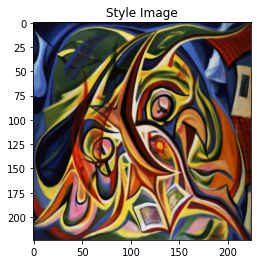

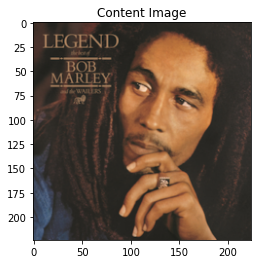

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layers = [vgg_names.index("conv4_2")]
style_layers = [vgg_names.index("conv1_1"), vgg_names.index("conv2_1"), vgg_names.index("conv3_1"), vgg_names.index("conv4_1"), vgg_names.index("conv5_1")]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested

vgg_content = VGGIntermediate(content_layers).cuda()
vgg_style = VGGIntermediate(style_layers).cuda()

# Cache the outputs of the content and style layers for their respective images
content_intermediates = vgg_content(content_image)
style_intermediates = vgg_style(style_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
print(style_intermediates)
print(style_intermediates.keys())
print(style_intermediates[0].shape)

{0: tensor([[[[-0.1753,  0.3071,  0.3261,  ...,  1.0550,  1.2727, -0.0802],
          [-0.4636,  0.3121,  0.2728,  ...,  1.5999,  1.5133, -0.2897],
          [-0.4650,  0.2976,  0.2210,  ...,  1.6407,  0.9087, -0.6196],
          ...,
          [-0.9261,  0.0517,  0.1610,  ..., -1.3079, -0.3610,  1.3385],
          [-0.7610,  0.0960,  0.1110,  ..., -1.5169, -0.7036,  1.0543],
          [-0.6883, -0.0657, -0.1322,  ..., -0.8890, -0.6391,  0.4942]],

         [[-3.9015, -0.1556, -0.0706,  ..., -0.0235, -2.1288,  2.3519],
          [-3.7013,  0.2684,  0.3410,  ..., -0.9205, -1.3377,  3.9321],
          [-3.8517,  0.1586,  0.2809,  ..., -1.7870, -0.6257,  3.8327],
          ...,
          [-3.1078,  0.3411,  0.3275,  ...,  0.3613,  0.9320,  3.3720],
          [-3.2086,  0.2426,  0.2148,  ..., -0.0202,  0.6384,  3.8023],
          [-0.0636,  2.6841,  2.6566,  ...,  3.1117,  3.4563,  5.2873]],

         [[ 2.6569,  4.0617,  4.0490,  ...,  2.6065,  2.7234,  5.8452],
          [ 0.3934,  0.483

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [8]:
def gram_matrix(input):

    batch_size, num_feature_maps, height, width = input.size()  

    # resize F
    F = input.view(batch_size * num_feature_maps, height * width)  

    # matrix multiplication
    G = torch.mm(F, F.t())  

    # normalize the gram matrix
    G = G.div(batch_size * num_feature_maps * height * width)

    return G

  
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        loss = .5 * torch.sum((input - self.target)**2)
        return loss
    
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.shape = target_feature.shape

    def forward(self, input):
        G = gram_matrix(input)
        coef = 1 / (4 * (self.shape[1] ** 2) * ((self.shape[2] * self.shape[3]) ** 2))
        loss = torch.sum(torch.square(G - self.target)) * coef * 1/5
        return loss

# Instantiate a content loss module for each content layer with the content reference image outputs for that layer for comparison
content_losses = []
style_losses = []


for i in content_layers:
    content_loss = ContentLoss(content_intermediates[i])
    content_losses.append(content_loss)

# Instantiate a style loss module for each style layer with the style reference image outputs for that layer for comparison
for i in style_layers:
    style_loss = StyleLoss(style_intermediates[i])
    style_losses.append(style_loss)


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



Content loss:
tensor(0., device='cuda:0', grad_fn=<AddBackward0>)
Style loss:
tensor(9.5584e-08, device='cuda:0', grad_fn=<AddBackward0>)
Total loss
tensor(9.5584e-08, device='cuda:0', grad_fn=<AddBackward0>)

Content loss:
tensor(5664363.5000, device='cuda:0', grad_fn=<AddBackward0>)
Style loss:
tensor(9.7380e-08, device='cuda:0', grad_fn=<AddBackward0>)
Total loss
tensor(56.6436, device='cuda:0', grad_fn=<AddBackward0>)

Content loss:
tensor(3330252., device='cuda:0', grad_fn=<AddBackward0>)
Style loss:
tensor(9.2309e-08, device='cuda:0', grad_fn=<AddBackward0>)
Total loss
tensor(33.3025, device='cuda:0', grad_fn=<AddBackward0>)

Content loss:
tensor(2590706.5000, device='cuda:0', grad_fn=<AddBackward0>)
Style loss:
tensor(9.1243e-08, device='cuda:0', grad_fn=<AddBackward0>)
Total loss
tensor(25.9071, device='cuda:0', grad_fn=<AddBackward0>)

Content loss:
tensor(2138194.2500, device='cuda:0', grad_fn=<AddBackward0>)
Style loss:
tensor(9.0972e-08, device='cuda:0', grad_fn=<AddBackwar

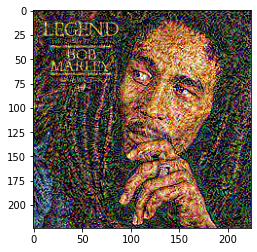

In [56]:
# Start with a copy of the content image

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 

# This is what was talked about in the video for memory management


def scope(content_image, vgg_content, vgg_style, content_layers, style_layers, content_losses, style_losses, epochs = 50, update_freq = 5):
    
    #your code for calling dataset and dataloader
    x = content_image.clone()
    optimizer = optim.Adam([x.requires_grad_()], lr=.05) 

    img_progress = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        y_hat_c = vgg_content(x)
        y_hat_s = vgg_style(x)

        content_loss = 0
        for i, cl in enumerate(content_layers):
            content_loss += content_losses[i](y_hat_c[cl])


        style_loss = style_losses[0](y_hat_s[style_layers[0]]) + style_losses[1](y_hat_s[style_layers[1]]) + style_losses[2](y_hat_s[style_layers[2]]) + style_losses[3](y_hat_s[style_layers[3]]) + style_losses[4](y_hat_s[style_layers[4]])
        # for i, sl in enumerate(style_layers):
        #    style_loss += style_losses[i](y_hat_s[sl])
        
        loss = content_loss + style_loss * 10000

        if epoch % update_freq == 0:
            print("Content loss:")
            print(content_loss)
            print("Style loss:")
            print(style_loss)
            print("Total loss")
            print(loss)
            print()
            img_progress.append(x.clamp(0,1))
            

        loss.backward()
        optimizer.step()
        

    return x, img_progress        
    


final_img, img_progress = scope(content_image, vgg_content, vgg_style, content_layers, style_layers, content_losses, style_losses)


# Show the image
# display(final_img)

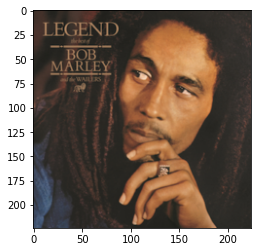

In [57]:
display(img_progress[0])

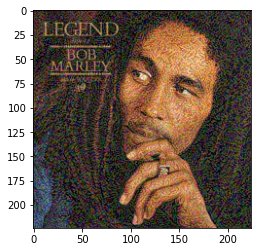

In [58]:
display(img_progress[1])

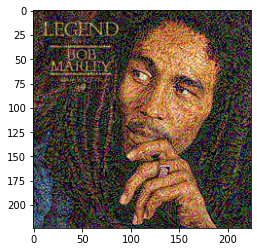

In [59]:
display(img_progress[2])

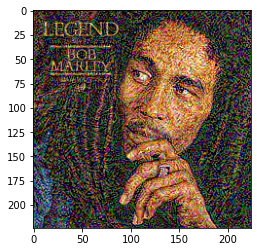

In [60]:
display(img_progress[3])

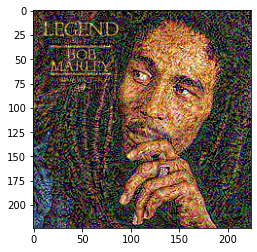

In [61]:
display(img_progress[4])

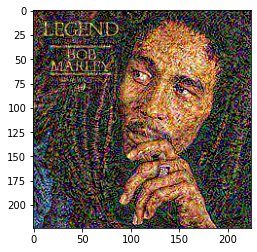

In [62]:
display(img_progress[5])

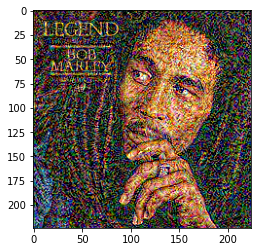

In [63]:
display(img_progress[6])

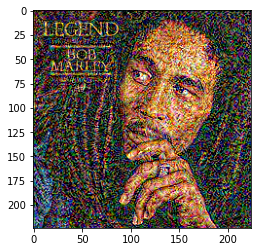

In [64]:
display(img_progress[7])

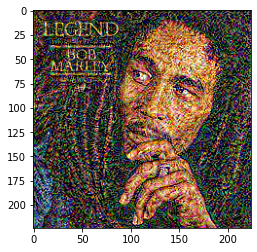

In [65]:
display(final_img.clamp(0, 1))

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

This is the sum squared loss of the content feature map (F^l) compared with the content feature map produced by a vgg of a given input image (P^l). The i,j's represent the individual entries of both F and P. The l superscript denotes the content layer (but we only use one content layer so it's not really necessary).

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

To make the gram matrix you need to matrix multiply the feature map with itself transposed. Their notation is a bunch of dot products for individual entries (i,j) of G. Again, the l superscript denotes the layer in question.

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

This computes the style loss for a given style layer l. This is the sum squared loss of the style feature map of the original image (A^l_ij) compared with the style feature map produced by a vgg of a given input image (G^l_ij). They sum this over every (i,j) entry. They also weight this loss by 1/(4*dimensions of the style feature map of original image).

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

The total style loss is the sum of each E^l (style layer loss) weighted by some coefficient w^l for each layer. Again, l represents a particular layer.


**DONE:**